# PyMC3 Sandbox

This notebook covers material from the [Getting Started](https://docs.pymc.io/notebooks/getting_started.html) and [Gaussian Processes](https://docs.pymc.io/Gaussian_Processes.html).

In [84]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import pymc3 as pm
import seaborn as sns

## Linear Regression (Getting Started Example)

Let's create a Bayesian modelling equivalent to OLS.  We want to determine the posteriors of $\alpha$, $\beta_1$, $\beta_2$ and $\sigma$ of the following set of equations:

\begin{eqnarray}
Y &\sim& \mathcal{N}(\mu, \sigma^2) \\
\mu &=& \alpha + \beta_1 X_1 + \beta_2 X_2
\end{eqnarray}

Reasonable priors are:

\begin{eqnarray}
\alpha &=& \mathcal{N}(0, 100) \\
\beta_i &=& \mathcal{N}(0, 100) \\
\sigma &\sim& |\mathcal{N}(0, 1)|
\end{eqnarray}

In [2]:
# Generate some fake data using NumPy.
np.random.seed(123)
n_obs = 10000
sigma = 1.6
alpha = 1.2
beta = (1.7, 2.9)

X1 = np.random.randn(n_obs)
X2 = np.random.randn(n_obs)
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(n_obs) * sigma

<IPython.core.display.Javascript object>


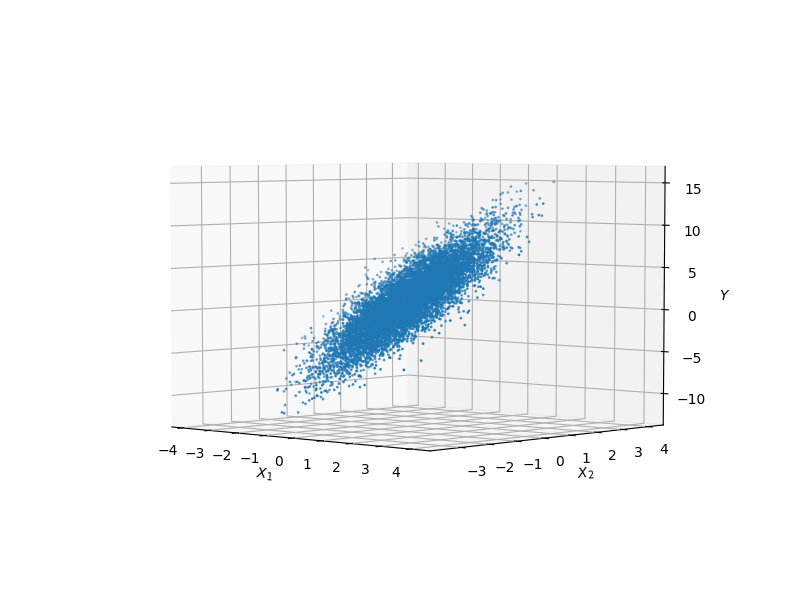

In [3]:
# Plot functional output, a tilted Gaussian
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X1, X2, Y, s=1)
ax.set_xlabel(r"$X_1$")
ax.set_ylabel(r"$X_2$")
ax.set_zlabel(r"$Y$");

In [4]:
# Model object that contains variables and solvers.
simple_linear_model = pm.Model()

# Context manager registers variables in `with` block.
with simple_linear_model:

    # Stochastic RVs for priors for unknown model parameters.
    # First argument is always the name, other arguments are parameters.
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    # Beta is an array of IID variables, specified by `shape`.  `shape` can be
    # multidimensional using a list-like rather than an integer.
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome.
    # This creates a deterministic random variable.
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations.
    # This is an observed stochastic ariable, and represents a data likelihood.
    # The data will not be changed by the fitting algorithm.
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

We now find the maximum a posteriori (MAP) estimate, the mode of the posterior distribution.

In [6]:
# Find the maximum a posteriori parameter values.
# This only gives a point estimate of the parameters and may be misleading if the mode isn't
# representative of the distribution.  By default, 'L-BFGS-B' is used.
map_estimate = pm.find_MAP(model=simple_linear_model, method='L-BFGS-B')

logp = -19,638, ||grad|| = 3,484.4: 100%|██████████| 21/21 [00:00<00:00, 1516.25it/s]  


In [7]:
map_estimate

{'alpha': array(1.20012189),
 'beta': array([1.69358674, 2.85838105]),
 'sigma_log__': array(0.46253537),
 'sigma': array(1.58809529)}

In [9]:
# Powell works better with discrete variables (and handles errors a bit better,
# given that I mistakenly fed it a zero-error Y and it worked fine).
map_estimate = pm.find_MAP(model=simple_linear_model, method='powell')

  0%|          | 0/5000 [00:00<?, ?it/s]/home/czhu/pipenv/bditto/lib/python3.6/site-packages/scipy/optimize/_minimize.py:500: RuntimeWarning: Method powell does not use gradient information (jac).
  RuntimeWarning)
logp = -19,295, ||grad|| = 2,648.1: 100%|██████████| 180/180 [00:00<00:00, 1899.07it/s] 


In [10]:
map_estimate

{'alpha': array(1.19879524),
 'beta': array([1.69179685, 2.86001144]),
 'sigma_log__': array(0.46255695),
 'sigma': array(1.58812957)}

Caveats to MAP estimates:
- For high-dimensional posteriors, possible to have areas of extreme density but low total probability due to small volume.
  - This will often happen in random-effect hierarchical models.
- Solvers usually only find local optimum.

Let's now sample the posterior.  This is by default done with `BinaryMetropolis` for binary variables, `Metropolis` for discrete ones, and No-U-Turn Sampler (`NUTS`, which uses the numerical gradient of the posterior for more efficient sampling) for continuous ones (since only continuous ones have a derivative).

Nuts requires a scaling matrix parameter, analogous to the variance parameter for the [jumping distribution in Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm#Intuition).  PyMC3 automatically initializes 

In [14]:
trace = pm.sample(model=simple_linear_model, draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:02<00:00, 2109.67draws/s]


In [19]:
trace['alpha']

array([1.20484401, 1.20556587, 1.22617052, ..., 1.18703965, 1.21618456,
       1.18015343])

In [18]:
trace['alpha'].shape

(4000,)

In [20]:
trace['beta']

array([[1.63553423, 2.86149134],
       [1.65440186, 2.85464485],
       [1.68008576, 2.854566  ],
       ...,
       [1.701694  , 2.84058873],
       [1.68257741, 2.87214003],
       [1.6982642 , 2.84705178]])

In [21]:
trace['beta'].shape

(4000, 2)

In [28]:
# Explicitly use the pm.Slice stepping method.
# This example shows why using the context manager is important - the same code run outside
# of the manager would look like:
# > trace2 = pm.sample(model=simple_linear_model, draws=1000, step=pm.Slice(model=simple_linear_model))
# which requires that we pass the `model` keyword to multiple functions.

with simple_linear_model:
    trace2 = pm.sample(draws=1000, step=pm.Slice())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:04<00:00, 1323.77draws/s]


<IPython.core.display.Javascript object>


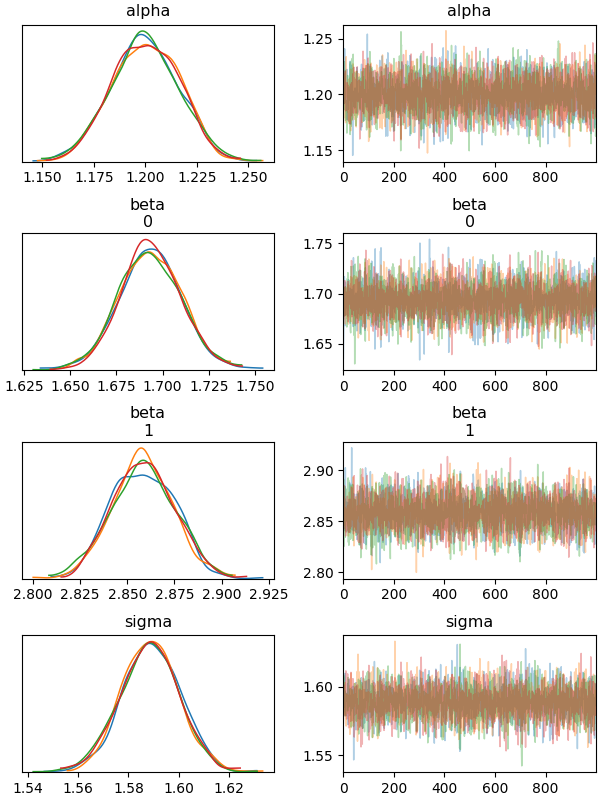

/home/czhu/pipenv/bditto/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/czhu/pipenv/bditto/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/czhu/pipenv/bditto/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/czhu/pipenv/bditto/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied

In [37]:
# Plot the trace using arviz.  We use this rather than pm.traceplot like the tutorial suggests because
# arviz properly plots each component of beta separately.
# https://stackoverflow.com/questions/52066058/trace-individual-dimensions-using-pymc3s-traceplot
import arviz as az

# Produce a KDE-estimated smoothed histogram and MC values plotted in sequential order
# (to test for burn-in I guess).  This will produce four curves for each variable, as there were
# for MC chains used in the trace.  Use combined=True to combine multiple lines into a single curve.
az.plot_trace(trace, figsize=(6, 8), combined=False);

In [46]:
# Get summary statistics, rounded to the nearest hundreth.
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.20,0.02,1.17,1.23,0.0,0.0,5311.0,5311.0,5294.0,3242.0,1.0
beta[0],1.69,0.02,1.66,1.73,0.0,0.0,5774.0,5766.0,5778.0,3330.0,1.0
beta[1],2.86,0.02,2.83,2.89,0.0,0.0,5035.0,5035.0,5030.0,3357.0,1.0
sigma,1.59,0.01,1.57,1.61,0.0,0.0,3972.0,3972.0,3984.0,2992.0,1.0


## Poisson Regression

Follows [this tutorial](https://docs.pymc.io/notebooks/GLM-poisson-regression.html).  Useful as an absolute trivial baseline model for collisions.

In [74]:
# Emulate study on sneezing as a function of antihistamine and alcohol use.

# Poisson variable represents number of sneezes per day, which is distributed
# as a Poisson RV.  The rate varies due to independent variables.
lambd_noalcohol_meds = 1    # no alcohol, took an antihist
lambd_alcohol_meds = 3      # alcohol, took an antihist
lambd_noalcohol_nomeds = 6  # no alcohol, no antihist
lambd_alcohol_nomeds = 36   # alcohol, no antihist

In [115]:
n_obs = 1000
np.random.seed(42)
# Generate a table of experimental outcomes, sampled using the lambdas above.
df = pd.DataFrame({
    'nsneeze': np.concatenate((np.random.poisson(lambd_noalcohol_meds, n_obs),
                               np.random.poisson(lambd_alcohol_meds, n_obs),
                               np.random.poisson(lambd_noalcohol_nomeds, n_obs),
                               np.random.poisson(lambd_alcohol_nomeds, n_obs))),
    'alcohol': np.concatenate((np.repeat(False, n_obs),
                               np.repeat(True, n_obs),
                               np.repeat(False, n_obs),
                               np.repeat(True, n_obs))),
    'nomeds': np.concatenate((np.repeat(False, n_obs),
                              np.repeat(False, n_obs),
                              np.repeat(True, n_obs),
                              np.repeat(True, n_obs)))})

In [116]:
# Check that we've done something sensible.
df.head()

,nsneeze,alcohol,nomeds
0,1,False,False
1,2,False,False
2,0,False,False
3,0,False,False
4,3,False,False


In [117]:
df.groupby(['alcohol','nomeds']).mean().unstack()

nsneeze        
nomeds    False   True 
alcohol                
False     0.975   5.961
True      2.964  35.939

<IPython.core.display.Javascript object>


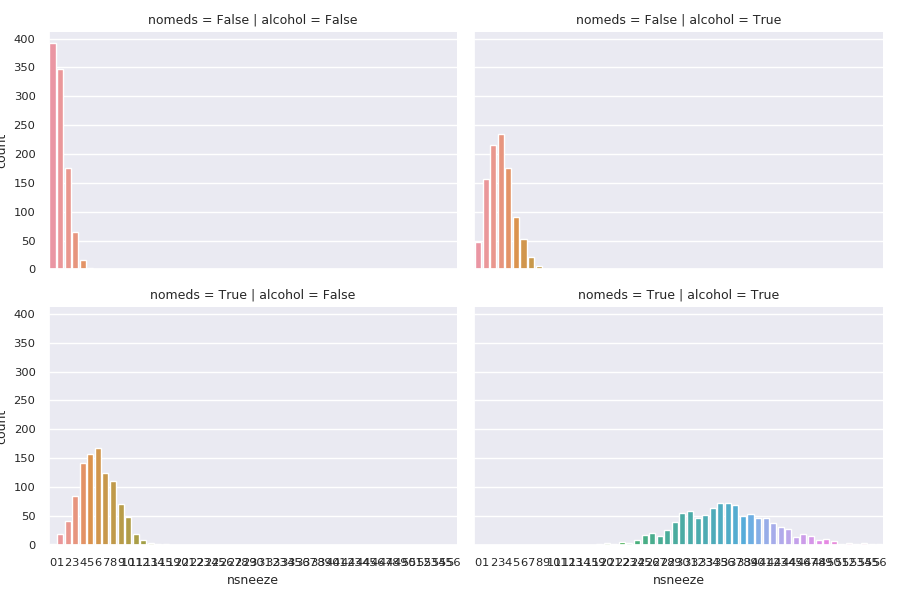

In [118]:
sns.set(font_scale=0.75)
g = sns.catplot(x='nsneeze', row='nomeds', col='alcohol', data=df,
                kind='count', height=3, aspect=1.5)

We've built generative model of sneezing:

\begin{eqnarray}
N_\mathrm{sneeze} &\sim& \mathrm{Poisson}(\lambda)\\
\ln(\lambda) &=& \beta_0 + \beta_1X_\mathrm{alcohol} + \beta_2X_\mathrm{antihist} + \beta_3X_\mathrm{alcohol}X_\mathrm{antihist}
\end{eqnarray}

(where the log-link comes from the [derivation of Poisson regression](https://www.cs.princeton.edu/~bee/courses/lec/lec_jan29.pdf)).  Let's build this out:

In [120]:
# Fill in design matrix (except for intercept dummy term) by adding a combined column.
df['alcohol and nomeds'] = df['alcohol'] & df['nomeds']

In [121]:
with pm.Model() as poisson_regression:

    # define priors, weakly informative Normal
    b0 = pm.Normal('b0_intercept', mu=0, sigma=10)
    b1 = pm.Normal('b1_alcohol', mu=0, sigma=10)
    b2 = pm.Normal('b2_nomeds', mu=0, sigma=10)
    b3 = pm.Normal('b3_alcohol:nomeds', mu=0, sigma=10)

    # define linear model and exp link function
    lambd = (b0 +
             b1 * df['alcohol'].values.astype(float) +
             b2 * df['nomeds'].values.astype(float) +
             b3 * df['alcohol and nomeds'].values.astype(float))

    ## Define Poisson likelihood
    y = pm.Poisson('y', mu=np.exp(lambd), observed=df['nsneeze'].values)

In [123]:
with poisson_regression:
    trace_poisson = pm.sample(1000, tune=2000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b3_alcohol:nomeds, b2_nomeds, b1_alcohol, b0_intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:24<00:00, 483.17draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [132]:
import re

def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs


def plot_traces_pymc(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, var_names=varnames, figsize=(8,nrows*1.4),
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(trcs, var_names=varnames).iterrows()]))

    for i, mn in enumerate(pm.summary(trcs, var_names=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')

<IPython.core.display.Javascript object>


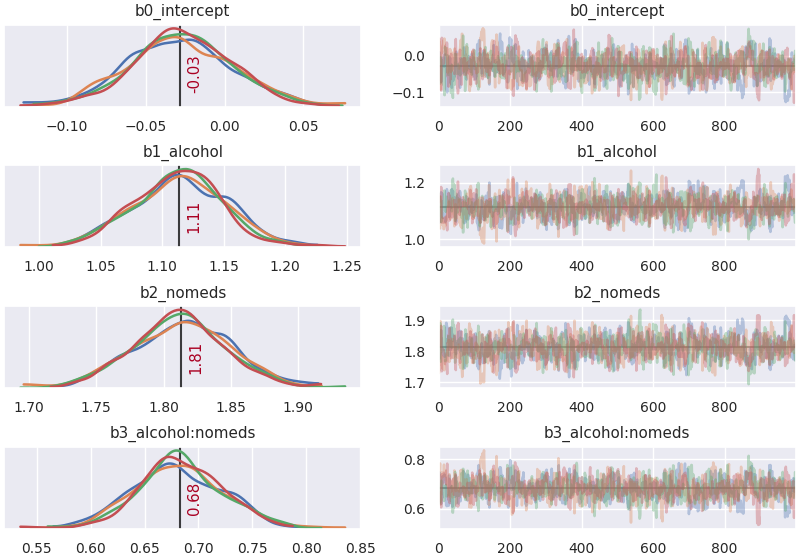

/home/czhu/pipenv/bditto/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/czhu/pipenv/bditto/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/czhu/pipenv/bditto/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/czhu/pipenv/bditto/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied

In [133]:
plot_traces_pymc(trace_poisson, [rv.name for rv in strip_derived_rvs(poisson_regression.unobserved_RVs)])

In [142]:
# We can just straight-up take an exponential since the x-values are boolean.
np.exp(pm.summary(trace_poisson)).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b0_intercept,0.97,1.03,0.92,1.04,1.0,1.0,1.544673e+296,1.544673e+296,1.544673e+296,inf,2.75
b1_alcohol,3.05,1.04,2.83,3.25,1.0,1.0,1.141368e+297,1.141368e+297,2.292499e+298,inf,2.75
b2_nomeds,6.13,1.04,5.74,6.54,1.0,1.0,1.372614e+303,1.372614e+303,1.372614e+303,inf,2.72
b3_alcohol:nomeds,1.98,1.04,1.84,2.13,1.0,1.0,7.494218e+304,1.372614e+303,inf,inf,2.75


Do these means make sense?  (Posterior means [minimize the squared error Bayes risk](https://en.wikipedia.org/wiki/Bayes_estimator#Posterior_mean).)

In [139]:
def check_poisson_fit(x_alcohol, x_antihist):
    return np.exp(-0.03 + 1.11 * x_alcohol + 1.81 * x_antihist + 0.68 * x_alcohol * x_antihist)

In [140]:
check_poisson_fit(0, 0)

0.9704455335485082

In [141]:
check_poisson_fit(1, 1)

35.516593151628484

That seems reasonable.

## Hierarchical Models

In [144]:
pd.read_csv(pm.get_data('rugby.csv'), index_col=0)

,home_team,away_team,home_score,away_score,year
0,Wales,Italy,23,15,2014
1,France,England,26,24,2014
2,Ireland,Scotland,28,6,2014
3,Ireland,Wales,26,3,2014
4,Scotland,England,0,20,2014
5,France,Italy,30,10,2014
6,Wales,France,27,6,2014
7,Italy,Scotland,20,21,2014
8,England,Ireland,13,10,2014
9,Ireland,Italy,46,7,2014
